In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import keras
from keras import layers
from keras.callbacks import EarlyStopping

import tensorflow as tf

2025-07-09 20:08:38.381504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752055718.472237   30050 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752055718.499929   30050 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752055718.696830   30050 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752055718.696874   30050 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752055718.696877   30050 computation_placer.cc:177] computation placer alr

In [2]:
# check GPU
from tensorflow.python.client import device_lib
display(tf.config.list_physical_devices("GPU"))
display(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

I0000 00:00:1752055722.779294   30050 gpu_device.cc:2019] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:10:00.0, compute capability: 8.9


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 617979103924330430
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5833228288
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13140918970889725715
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:10:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [ ]:
data_file_path = "../datasets/red_wine/"

In [4]:
# setup plotting
# display(plt.style.available)
plt.style.use("seaborn-v0_8-whitegrid")
# setup defaults
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large",
       titleweight = "bold", titlesize = 18, titlepad = 10)

In [5]:
red_wine = pd.read_csv(data_file_path + "red_wine.csv")
display(red_wine.shape)
display(red_wine.head())

(1599, 12)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
# pick out random data to train
df_train = red_wine.sample(frac=0.7, random_state=0)

# remove the training data from valid data
df_valid = red_wine.drop(df_train.index)
display(df_train.head())

# NOTE: commented out to test batch normalization
# scale to [0, 1]
# max_ = df_train.max(axis=0)
# min_ = df_train.min(axis=0)
# df_train = (df_train - min_) / (max_ - min_)
# df_valid = (df_valid - min_) / (max_ - min_)
display(df_train.head())

# remove target value from training data
X_train = df_train.drop("quality", axis=1)
X_valid = df_valid.drop("quality", axis=1)
y_train = df_train["quality"]
y_valid = df_valid["quality"]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6
979,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6
979,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,5


In [7]:
# keras model
red_wine_model_keras_sequential = keras.Sequential(
    [
        keras.Input((X_train.shape[1],)),
        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),

        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        
        layers.Dense(1),
    ]
)

I0000 00:00:1752055722.872991   30050 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:10:00.0, compute capability: 8.9


In [8]:
# using "adam" - a "self-tuning" SGD algorithm
red_wine_model_keras_sequential.compile(
    optimizer="adam",
    loss="mae",
)

In [9]:
# train
keras_sequential_early_stopping = EarlyStopping(
    min_delta=0,
    patience=20,
    restore_best_weights=True,
)
history_keras_sequential = red_wine_model_keras_sequential.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=200,
    callbacks=[keras_sequential_early_stopping],
)

Epoch 1/200


I0000 00:00:1752055725.583419   30917 service.cc:152] XLA service 0x752c700121b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752055725.583447   30917 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-07-09 20:08:45.641198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752055725.934880   30917 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/5 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 5.6808

I0000 00:00:1752055727.518223   30917 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 587ms/step - loss: 6.6551 - val_loss: 24.6999
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.5527 - val_loss: 3.0219
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5.1692 - val_loss: 2.8095
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 4.8648 - val_loss: 2.6241
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.6159 - val_loss: 2.3626
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.3089 - val_loss: 2.1412
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0170 - val_loss: 2.3692
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5932 - val_loss: 4.0940
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.1372 - val_loss: 4.6235
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.5896 - val_loss: 1.8679
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0865 - val_loss: 4.2394
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7258 - val_loss: 4.7176

<Axes: >

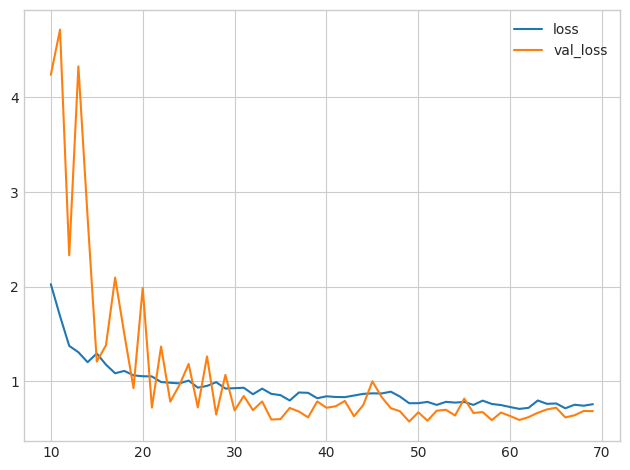

In [13]:
history_keras_sequential_df = pd.DataFrame(history_keras_sequential.history)
history_keras_sequential_df[10:].plot()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


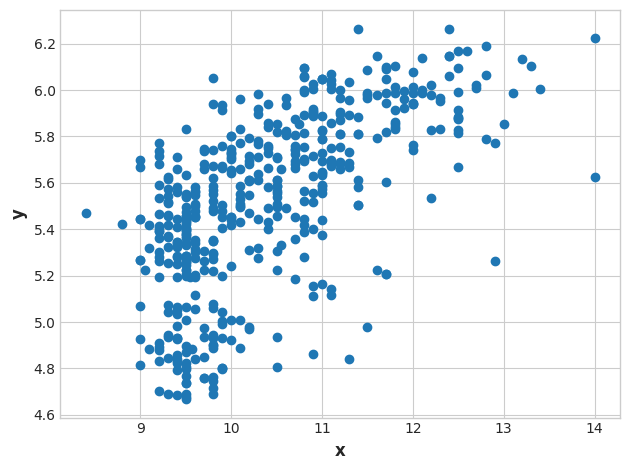

In [11]:
x = X_valid["alcohol"]
y = red_wine_model_keras_sequential.predict(X_valid)

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
w, b = red_wine_model_keras_sequential.get_weights()[:2]
plt.show()